#### Definition of the model

* finding the optimal parameters
* finding the optimal equations for mu and qs
* applying **Latin Hypercube Sampling** for generating parameter sets
* calculating the **RMSE** of model and experiment

#### Code

- First step: Testing each equation for qs with every parameter set that is generated with LHS sampling
- Second step: Loading & Comparison of parameter sets
- Third step: Testing parameters for chosen equation for qs (No.2)
- Fourth step: Manual understanding by changing the parameters one by one

In [1]:
import pandas as pd
import numpy as np
from C_model import get_LHS_samples, objective_function, objective_function_estimation
from C_model import model_estimation
from C_model import plot_save, plot_save_estimation, plot_show

##### First step:

In [3]:
# Define possible equations for qs
qs0 = lambda qs_max, c_glucose, Ks: qs_max * c_glucose / (Ks + c_glucose) # -- MONOD
qs1 = lambda qs_max, c_glucose, Ks, Ki, glu_met: qs_max * c_glucose / (Ks + c_glucose) * (Ki / (Ki + glu_met)) # -- MONOD + NON COMPETITIVE INHIBITION
qs2 = lambda qs_max, c_glucose, Ks, c_biomass, lag: qs_max * c_glucose / (Ks + c_glucose) * (1 / (np.exp(c_biomass * lag))) # -- MONOD + METABOLIZED GLU

# Saving all equations in each list
qs_all=[qs0, qs1, qs2]

In [4]:
# Set the number of samples and parameters
num_samples = 100
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [0.3, 0.5],    # Range for parameter 0 Yxs
    [0.5, 1.5],    # Range for parameter 1 qs_max
    [0.0, 1.0],   # Range for parameter 2 - Ks
    [1.0, 11.0],   # Range for parameter 3 - Ki
    [0.0, 0.01],    # Range for parameter 4 - m_s
    [0.001, 1.0],  # Range for parameter 5 - lag
]

In [5]:
LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)
LHS_samples.shape

(100, 6)

In [6]:
df_all_sets = pd.DataFrame(columns=['set', 'qs', 'Yxs', 'qs_max', 'Ks', 'Ki', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])
    for j in range(len(qs_all)):
        qs_eq = qs_all[j]; num_qs = j   

        # Make the predictions and calculate the error
        rmse, time_pred, biomass_pred, substrate_pred, volume_pred = objective_function(init_p, qs_eq, num_qs)
        # save the parameters in a dataframe
        append_list=[set_num, j, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
        rmse_one_set.append(append_list)

        # Make a plot and save it
        title = f'set{set_num}/ qs{j} - rmse: {round(rmse, 3)}'
        plot_name = f'set{set_num}_qs{j}_rmse{int(rmse)}'

        #if rmse <= float(6):
            #plot_save(time_pred, biomass_pred, substrate_pred, volume_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'qs', 'Yxs', 'qs_max', 'Ks', 'Ki', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)


df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
#df_all_sets.to_csv(f'data/estimation/0207_6/data.csv')

df_all_sets.head(10)

,set,qs,Yxs,qs_max,Ks,Ki,m_s,lag,rmse
284,94,2,0.493694,0.959567,0.076915,9.987638,0.005879,0.233722,4.663
29,9,2,0.491772,1.083275,0.969550,9.497721,0.001579,0.204987,4.671
263,87,2,0.378034,1.374070,0.792899,7.009797,0.000028,0.263490,4.678
8,2,2,0.377371,1.123265,0.789786,2.052882,0.008987,0.225642,4.741
182,60,2,0.365399,1.365260,0.829923,6.779025,0.006623,0.308486,4.887
227,75,2,0.357299,1.236725,0.234429,3.863658,0.001153,0.316360,5.027
233,77,2,0.437372,0.733023,0.993518,1.204770,0.008840,0.213390,5.133
242,80,2,0.474098,1.030183,0.146489,9.611732,0.003297,0.175370,5.140
254,84,2,0.482165,0.548027,0.112082,3.730518,0.008158,0.167621,5.156
14,4,2,0.416812,1.391724,0.916171,6.610556,0.006516,0.342987,5.192


##### Second step:

In [7]:
# Loading the saved paramter sets ranked based on the RMSE
## it can be seen that generally qs2 has the best fit for the model
df_LHS1 = pd.read_csv('data/estimation/0207_1/data.csv')
df_LHS2 = pd.read_csv('data/estimation/0207_2/data.csv')
df_LHS3 = pd.read_csv('data/estimation/0207_3/data.csv')
df_LHS6 = pd.read_csv('data/estimation/0207_6/data.csv')

In [8]:
# in order to be sure to choose qs2 for the further model development
## I want to see the best fits for qs0 and qs1 --> in 0207_3, set 27 has the best fit for both
qs_p27 = df_LHS3[df_LHS3['set'] == 27]
qs_p27

,Unnamed: 0,set,qs,Yxs,qs_max,Ks,Ki,m_s,lag,rmse
57,83,27,2,0.326818,0.520688,0.490661,3.177443,0.221605,0.50004,7.360
93,82,27,1,0.326818,0.520688,0.490661,3.177443,0.221605,0.50004,43.126
94,81,27,0,0.326818,0.520688,0.490661,3.177443,0.221605,0.50004,46.566


In [9]:
p27 = [0.3268, 0.5207, 0.4907, 3.1774, 0.2216, 0.5000]
p43 = [0.3438, 0.9786, 0.0035, 8.4651, 0.0330, 0.2240]
p13 = [0.3902, 1.2433, 0.2794, 9.1011, 0.0627, 0.2494]

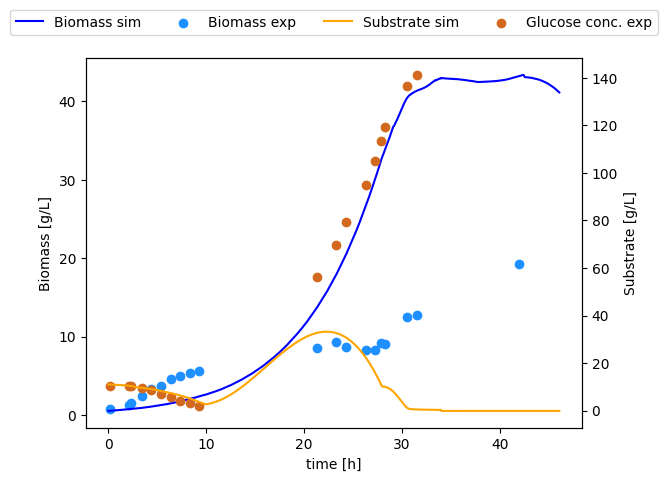

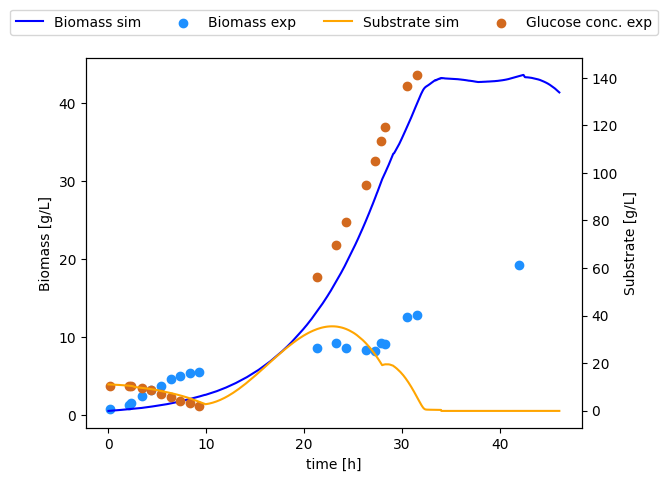

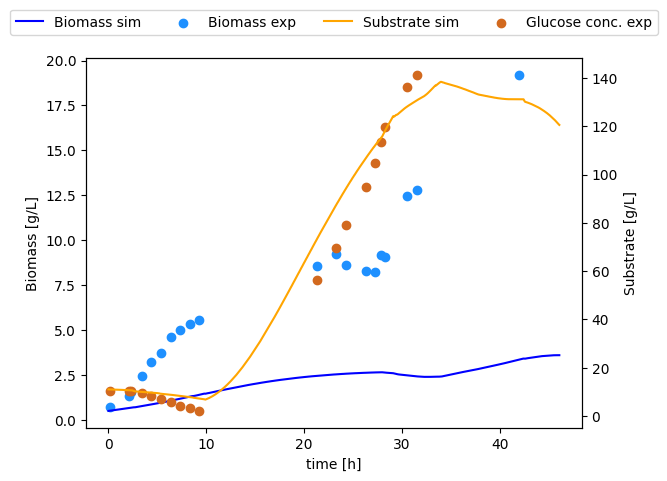

In [10]:
for j in range(len(qs_all)):
    qs_eq = qs_all[j]; num_qs = j
    rmse, time_pred, biomass_pred, substrate_pred, volume_pred = objective_function(p27, qs_eq, num_qs)
    plot_show(time_pred, biomass_pred, substrate_pred)

##### Third step:

In [2]:
# Set the number of samples and parameters
num_samples = 100
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [0.459, 0.460],     # Range for parameter 0 - Yxs
    [0.0001, 0.0023], # Range for parameter 1 - Yco2s
    [1.125, 1.126],     # Range for parameter 2 - qs_max
    [0.6810, 0.6815],     # Range for parameter 3 - Ks
    [0.0092, 0.0096],    # Range for parameter 4 - m_s
    [0.1910, 0.1916],   # Range for parameter 5 - lag
]

In [3]:
LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)
LHS_samples.shape

(100, 6)

In [4]:
df_all_sets = pd.DataFrame(columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])

    # Make the predictions and calculate the error
    rmse, time_pred, biomass_pred, substrate_pred, co2_pred = objective_function_estimation(init_p)
    # save the parameters in a dataframe
    append_list=[set_num, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
    rmse_one_set.append(append_list)

    # Make a plot and save it
    title = f'set{set_num}/ rmse: {round(rmse, 3)}'
    plot_name = f'set{set_num}_rmse{int(rmse)}'

    if rmse <= float(6):
        plot_save_estimation(time_pred, biomass_pred, substrate_pred, co2_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)

df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/batch_no2/estimation/data2.csv')

df_all_sets.head(10)

,set,Yxs,Yc02s,qs_max,Ks,m_s,lag,rmse
36,36,0.459087,0.001177,1.125415,0.681233,0.009227,0.191553,4.324
79,79,0.459123,0.000317,1.125171,0.681177,0.009269,0.191512,4.325
17,17,0.459336,0.000564,1.125894,0.681160,0.009204,0.191573,4.325
89,89,0.459776,0.000110,1.125548,0.681283,0.009319,0.191597,4.325
1,1,0.459909,0.000624,1.125443,0.681435,0.009306,0.191563,4.326
73,73,0.459119,0.001296,1.125587,0.681257,0.009233,0.191474,4.326
48,48,0.459769,0.000836,1.125667,0.681195,0.009217,0.191506,4.326
30,30,0.459280,0.001347,1.125519,0.681141,0.009328,0.191519,4.326
19,19,0.459164,0.001202,1.125820,0.681020,0.009221,0.191480,4.326
90,90,0.459260,0.002158,1.125230,0.681236,0.009259,0.191455,4.326


##### Fourth step:

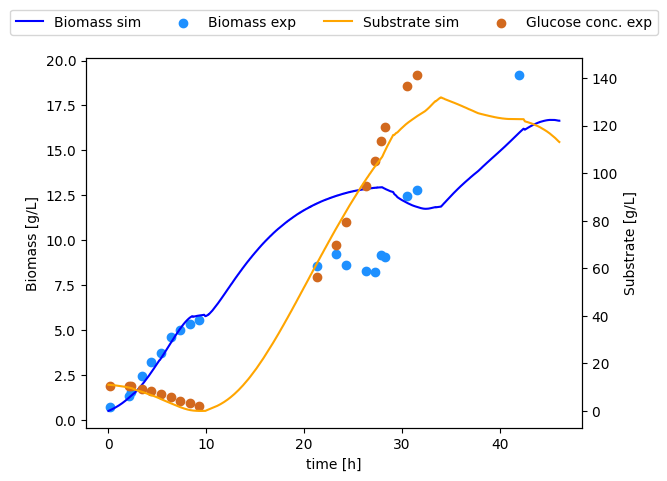

In [14]:
# in the 3rd step only the parameters were tested that are needed for the model
## set 30 was chosen as a starting point because of the following criteria
#- it covers the 3 fast growth phases
#- it covers the slow down phases when glucose was limited and when another limitation occured

p30 = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]
time_pred, biomass_pred, substrate_pred, volume_pred = model_estimation(p30)
plot_show(time_pred, biomass_pred, substrate_pred)

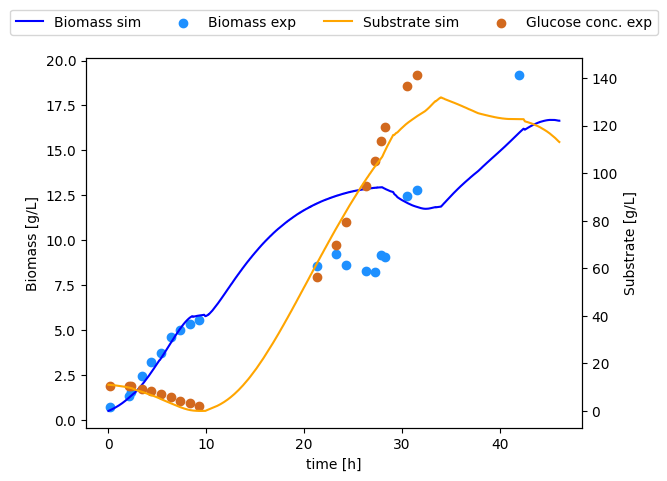

In [15]:
# manually changing one parameter and checking what happens --> slides called 1007_Update
p30 = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]
time_pred, biomass_pred, substrate_pred, volume_pred = model_estimation(p30)
plot_show(time_pred, biomass_pred, substrate_pred)

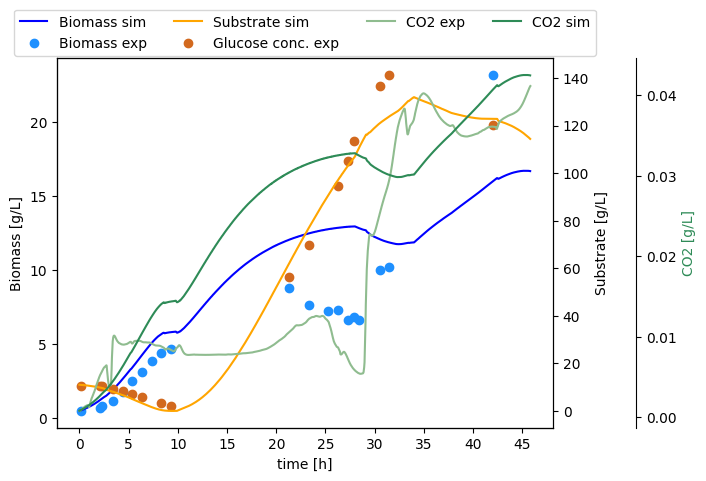

In [2]:
# in the 3rd step only the parameters were tested that are needed for the model
## set 30 was chosen as a starting point because of the following criteria
#- it covers the 3 fast growth phases
#- it covers the slow down phases when glucose was limited and when another limitation occured

p36 = [0.4597, 0.001177, 1.1255, 0.6814, 0.0094, 0.1913]
time_pred, biomass_pred, substrate_pred, co2_pred = model_estimation(p36)
plot_show(time_pred, biomass_pred, substrate_pred, co2_pred)